In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/multitask_gam/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/03_multitask_gam.py'
d = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
d = imodelsx.process_results.average_over_seeds(
    d, experiment_filename, key_to_average_over='seed'
)
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[(r.use_multitask == 0) * (r.linear_penalty != 'ridge')], actually_delete=True)
# imodelsx.process_results.get_experiment_keys(r, experiment_filename)

[2024-03-11 08:58:26,904] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_bui

### Compare baseline to best setting

In [17]:
r2_table

use_multitask,standard,multitask,num_features,num_samples,feature_over_samples,num_features_log,improvement
dataset_name,,,,,,,
1027_ESL,0.827261,0.810613,4.0,390.0,0.010256,1.386294,-0.016649
1028_SWD,0.333585,0.327629,10.0,800.0,0.012500,2.302585,-0.005956
1029_LEV,0.596684,0.585388,4.0,800.0,0.005000,1.386294,-0.011296
1030_ERA,0.344068,0.339012,4.0,800.0,0.005000,1.386294,-0.005056
1089_USCrime,0.755083,0.790034,13.0,37.0,0.351351,2.564949,0.034951
...,...,...,...,...,...,...,...
friedman1,0.839164,0.891116,10.0,160.0,0.062500,2.302585,0.051952
friedman2,0.980068,0.985097,4.0,160.0,0.025000,1.386294,0.005028
friedman3,0.976551,0.985478,4.0,160.0,0.025000,1.386294,0.008927


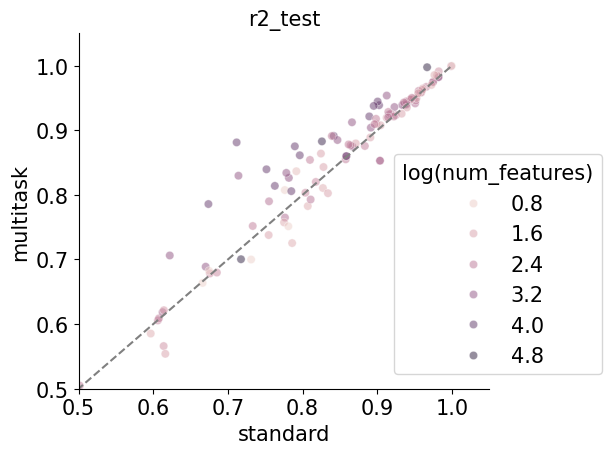

,setting,n_datasets,frac_improved,avg_change
0,full,130,0.65,0.00
1,many_features,18,0.94,0.05
2,well_predicted_standard,114,0.70,0.01


In [29]:
# filter datasets for which there is a row with use_multitask=0 and use_multitask=1 (done running)
d2 = d[
    (d.linear_penalty == 'ridge') * (d.n_boosting_rounds == 0) *
    (d.interactions == 0.95) * (d.use_onehot_prior == 0) *
    (d.use_input_normalization == 1)
]
d2 = d2.groupby(['dataset_name'])
d2 = d2.filter(lambda x: len(x) == 2)

# pivot table for d2 based on dataset_name, use_multitask, and r2_test
metric = 'r2_test'
r2_table = d2.pivot_table(index=['dataset_name'], columns=[
    'use_multitask'], values=metric)

# add num_features based on dataset_name
n_features = d2.groupby(['dataset_name']).first().n_features
n_samples = d2.groupby(['dataset_name']).first().n_samples

# add some metadata filters
r2_table['num_features'] = n_features
r2_table['num_samples'] = n_samples
r2_table['feature_over_samples'] = r2_table['num_features'].astype(
    int) / r2_table['num_samples'].astype(int)
r2_table = r2_table.rename(columns={0: 'standard', 1: 'multitask'})


plt.plot([0, 1], [0, 1], '--', color='gray')
# hue on log scale
r2_table['num_features_log'] = np.log(r2_table['num_features'])
sns.scatterplot(data=r2_table, x='standard',
                y='multitask', hue='num_features_log', alpha=0.5)
plt.legend(loc='center right', bbox_to_anchor=(
    1.3, 0.35), title='log(num_features)')
plt.title(metric, fontsize='medium')
plt.xlim([0.5, 1.05])
plt.ylim([0.5, 1.05])
plt.savefig('../figs/r2_test.pdf', bbox_inches='tight')
plt.show()


r2_table['improvement'] = r2_table['multitask'] - r2_table['standard']
summ = defaultdict(list)
summ['setting'].append('full')
summ['n_datasets'].append(len(r2_table))
summ['frac_improved'].append(
    (r2_table['improvement'] > 0).mean())
summ['avg_change'].append(
    (r2_table['improvement']).mean())
many_features = r2_table['num_features'] > 25
if many_features.sum() > 0:
    summ['setting'].append('many_features')
    summ['n_datasets'].append(many_features.sum())
    summ['frac_improved'].append(
        (r2_table['improvement'][many_features] > 0).mean())
    summ['avg_change'].append(
        r2_table['improvement'][many_features].mean())

well_predicted_standard = r2_table['standard'] > 0.5
if well_predicted_standard.sum() > 0:
    summ['setting'].append('well_predicted_standard')
    summ['n_datasets'].append(well_predicted_standard.sum())
    summ['frac_improved'].append(
        (r2_table['improvement'][well_predicted_standard] > 0).mean())
    summ['avg_change'].append(
        r2_table['improvement'][well_predicted_standard].mean())
display(pd.DataFrame(summ).round(2))
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# display(r2_table.sort_values('improvement', ascending=False).round(2))

### Compare different settings

In [164]:
cols = [
    'use_multitask', 'interactions', 'n_boosting_rounds', 'use_renormalize_features',
    'use_onehot_prior', 'use_input_normalization', 'linear_penalty',

]

groups = d.groupby(cols)
display(groups.size())

dset_names = [set(d.loc[g]['dataset_name'].values)
              for g in groups.groups.values()]
dset_names_shared = list(set.intersection(*dset_names))
print(len(dset_names_shared), 'completed shared datasets')
dc = d[d.dataset_name.isin(dset_names_shared)]

use_multitask  interactions  n_boosting_rounds  use_renormalize_features  use_onehot_prior  use_input_normalization  linear_penalty
0              0.00          0                  0.0                       1                 0                        ridge             130
                                                                                            1                        ridge             130
               0.95          0                  0.0                       1                 0                        ridge             130
                                                                                            1                        ridge             130
1              0.00          0                  0.0                       1                 0                        ridge              72
                                                                                            1                        ridge              89
               0.95          0    

28 completed shared datasets


In [165]:
# compute stats per group
groups = dc.groupby(cols)
group_idxs = list(groups.groups.values())
baseline_group = dc.loc[group_idxs[3].values].sort_values(by='dataset_name')
stat_cols = defaultdict(list)
for group in groups.groups.values():
    g = dc.loc[group].sort_values(by='dataset_name')
    stat_cols['win_rate'].append(
        (g['r2_test'].values >=
         baseline_group['r2_test'].values).mean())
    stat_cols['r2_test__>=25_features'] = g[g['n_features']
                                            >= 25]['r2_test'].mean()
    stat_cols['r2_test'].append(g['r2_test'].mean())
stat_cols = pd.DataFrame(stat_cols)

# save with index
stats = groups['r2_test'].mean().reset_index()
for col in stat_cols.columns:
    stats[col] = stat_cols[col].values


# color last 2 columns by value
display(
    stats
    .style
    .background_gradient(
        cmap='viridis', subset=['r2_test', 'r2_test__>=25_features']
    )
    .format(precision=3)
)

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,use_multitask,interactions,n_boosting_rounds,use_renormalize_features,use_onehot_prior,use_input_normalization,linear_penalty,r2_test,win_rate,r2_test__>=25_features
0,0,0.000,0,0.000,1,0,ridge,0.733,0.143,nan
1,0,0.000,0,0.000,1,1,ridge,0.724,0.107,nan
2,0,0.950,0,0.000,1,0,ridge,0.786,0.929,nan
3,0,0.950,0,0.000,1,1,ridge,0.777,1.000,nan
4,1,0.000,0,0.000,1,0,ridge,-2443.000,0.143,nan
5,1,0.000,0,0.000,1,1,ridge,0.693,0.143,nan
6,1,0.950,0,0.000,0,1,ridge,0.758,0.500,nan
7,1,0.950,0,0.000,1,0,ridge,-24889.105,0.500,nan
8,1,0.950,0,0.000,1,1,ridge,0.755,0.500,nan
9,1,0.950,0,1.000,1,1,ridge,0.023,0.286,nan
